In [1]:
# -*- coding: utf-8 -*-
"""
Improved Weather Prediction Model
Handles messy radiation and cloud coverage data
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import warnings
warnings.filterwarnings('ignore')


In [4]:
# ============================================================================
# 1. DATA LOADING AND INITIAL EXPLORATION
# ============================================================================

print("="*70)
print("WEATHER PREDICTION MODEL - IMPROVED VERSION")
print("="*70)

# Load the data
df = pd.read_csv('PKB.csv')
print(f"\n✅ Data loaded successfully!")
print(f"   Shape: {df.shape}")
print(f"   Date range: {df['Datetime'].iloc[0]} to {df['Datetime'].iloc[-1]}")

# Convert datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

# Drop unnecessary columns
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)


WEATHER PREDICTION MODEL - IMPROVED VERSION

✅ Data loaded successfully!
   Shape: (5000, 16)
   Date range: 2025-07-24 16:00:00 to 2026-02-17 23:00:00


In [16]:

# ============================================================================
# 2. HANDLE MISSING VALUES STRATEGICALLY
# ============================================================================

print("\n" + "="*70)
print("2. HANDLING MISSING VALUES")
print("="*70)

# Check missing values
missing_before = df.isnull().sum()
print(f"\nMissing values before treatment:\n{missing_before[missing_before > 0]}")

# For lag features, we'll use forward fill then backward fill
lag_cols = [col for col in df.columns if 'lag' in col]
for col in lag_cols:
    df[col] = df[col].ffill().bfill()

# For Relative_Humidity which has some missing values
df['Relative_Humidity(%)'] = df['Relative_Humidity(%)'].fillna(
    df.groupby(df['Datetime'].dt.hour)['Relative_Humidity(%)'].transform('median')
).ffill().bfill()

# Check after filling
missing_after = df.isnull().sum()
print(f"\nMissing values after treatment: {missing_after.sum()}")



2. HANDLING MISSING VALUES

Missing values before treatment:
Relative_Humidity(%)    48
dtype: int64

Missing values after treatment: 0


In [19]:

# ============================================================================
# 3. CREATE ENHANCED FEATURES
# ============================================================================

print("\n" + "="*70)
print("3. CREATING ENHANCED FEATURES")
print("="*70)

# Extract datetime features
df['hour'] = df['Datetime'].dt.hour
df['day'] = df['Datetime'].dt.day
df['month'] = df['Datetime'].dt.month
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['quarter'] = df['Datetime'].dt.quarter
df['dayofyear'] = df['Datetime'].dt.dayofyear

# Cyclical encoding for time features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

print("✅ Time-based features created")



3. CREATING ENHANCED FEATURES
✅ Time-based features created


In [24]:

# ============================================================================
# 4. SMART HANDLING OF RADIATION AND CLOUD COVERAGE
# ============================================================================

print("\n" + "="*70)
print("4. SMART HANDLING OF RADIATION & CLOUD COVERAGE")
print("="*70)

# Cap extreme values (optional, based on domain knowledge)
radiation_cap = df['Radiation(W/m^2)'].quantile(0.99)
df['Radiation(W/m^2)_capped'] = df['Radiation(W/m^2)'].clip(upper=radiation_cap)

# Create binary feature for day/night
df['is_daytime'] = ((df['hour'] >= 6) & (df['hour'] <= 18)).astype(int)
df['radiation_present'] = (df['Radiation(W/m^2)'] > 5).astype(int)

# Rolling statistics for radiation (smoothens the noise)
df['rad_roll_mean_3'] = df['Radiation(W/m^2)'].rolling(window=3, min_periods=1).mean()
df['rad_roll_mean_6'] = df['Radiation(W/m^2)'].rolling(window=6, min_periods=1).mean()
df['rad_roll_std_6'] = df['Radiation(W/m^2)'].rolling(window=6, min_periods=1).std()

# For cloud coverage, create smoothed versions
df['cloud_roll_mean_3'] = df['Cloud_Coverage(%)'].rolling(window=3, min_periods=1).mean()
df['cloud_roll_mean_6'] = df['Cloud_Coverage(%)'].rolling(window=6, min_periods=1).mean()
df['cloud_roll_std_6'] = df['Cloud_Coverage(%)'].rolling(window=6, min_periods=1).std()

# Fill NaN values created by rolling windows (CORRECTED)
df = df.ffill().bfill()

print("✅ Radiation and cloud features enhanced")



4. SMART HANDLING OF RADIATION & CLOUD COVERAGE
✅ Radiation and cloud features enhanced


In [27]:
# ============================================================================
# 5. CREATE LAG FEATURES WITH ADAPTIVE WINDOWS
# ============================================================================

print("\n" + "="*70)
print("5. CREATING LAG FEATURES")
print("="*70)

targets = [
    'Temperature(°C)', 'Radiation(W/m^2)', 'Cloud_Coverage(%)',
    'Rain(mm/hour)', 'Relative_Humidity(%)', 'Wind_Speed(m/s)',
    'Pressure(kPa'
]

# Use different lag windows for different features
lag_config = {
    'Temperature(°C)': [1, 3, 6, 12, 24],
    'Radiation(W/m^2)': [1, 2, 3, 6, 12, 24],
    'Cloud_Coverage(%)': [1, 2, 3, 6, 12],
    'Rain(mm/hour)': [1, 2, 3, 6, 12],
    'Relative_Humidity(%)': [1, 3, 6, 12, 24],
    'Wind_Speed(m/s)': [1, 2, 3, 6, 12, 24],
    'Pressure(kPa': [1, 3, 6, 12, 24]
}

for feature in targets:
    if feature in lag_config:
        for lag in lag_config[feature]:
            df[f'{feature}_lag{lag}'] = df[feature].shift(lag)

print("✅ Lag features created")

# Drop rows with NaN from lag features
initial_rows = len(df)
df = df.dropna().reset_index(drop=True)
print(f"✅ Dropped {initial_rows - len(df)} rows with NaN (from {initial_rows} to {len(df)})")



5. CREATING LAG FEATURES
✅ Lag features created
✅ Dropped 24 rows with NaN (from 5000 to 4976)


In [30]:

# ============================================================================
# 6. PREPARE FEATURES FOR MODELING
# ============================================================================

print("\n" + "="*70)
print("6. PREPARING FEATURES FOR MODELING")
print("="*70)

# Define features to use
base_features = ['hour', 'day', 'month', 'dayofweek', 'quarter', 
                 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
                 'day_sin', 'day_cos', 'is_daytime']

# Add all lag and roll features
feature_cols = base_features.copy()
for col in df.columns:
    if any(x in col for x in ['_lag', '_roll', '_capped', 'radiation_present']):
        if col not in targets:  # exclude target columns
            feature_cols.append(col)

# Ensure all feature columns exist
feature_cols = [col for col in feature_cols if col in df.columns]
print(f"📊 Using {len(feature_cols)} features")

# Separate features and targets
X = df[feature_cols].copy()
y = df[targets].copy()

print(f"\n📊 Feature matrix shape: {X.shape}")
print(f"🎯 Target matrix shape: {y.shape}")



6. PREPARING FEATURES FOR MODELING
📊 Using 60 features

📊 Feature matrix shape: (4976, 60)
🎯 Target matrix shape: (4976, 7)


In [33]:

# ============================================================================
# 7. TIME-BASED SPLIT (CRITICAL FOR TIME SERIES)
# ============================================================================

print("\n" + "="*70)
print("7. TIME-BASED TRAIN/TEST SPLIT")
print("="*70)

# Use 80% for training, 20% for testing (chronologically)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"📅 Training period: {df['Datetime'].iloc[0]} to {df['Datetime'].iloc[split_idx-1]}")
print(f"📅 Testing period:  {df['Datetime'].iloc[split_idx]} to {df['Datetime'].iloc[-1]}")
print(f"📊 Training samples: {len(X_train)}")
print(f"📊 Testing samples:  {len(X_test)}")



7. TIME-BASED TRAIN/TEST SPLIT
📅 Training period: 2025-07-25 16:00:00 to 2026-01-07 11:00:00
📅 Testing period:  2026-01-07 12:00:00 to 2026-02-17 23:00:00
📊 Training samples: 3980
📊 Testing samples:  996


In [36]:

# ============================================================================
# 8. SCALE FEATURES (BUT NOT TARGETS)
# ============================================================================

print("\n" + "="*70)
print("8. FEATURE SCALING")
print("="*70)

# Use RobustScaler which is less sensitive to outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Features scaled using RobustScaler")



8. FEATURE SCALING
✅ Features scaled using RobustScaler


In [39]:
# ============================================================================
# 9. TRAIN MODELS
# ============================================================================

print("\n" + "="*70)
print("9. TRAINING MODELS")
print("="*70)

# Model 1: XGBoost (good for complex patterns)
xgb_model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
)

# Model 2: Random Forest (good for handling noise)
rf_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
)

# Train models
print("\n🚀 Training XGBoost...")
xgb_model.fit(X_train_scaled, y_train)
print("✅ XGBoost trained")

print("\n🚀 Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)
print("✅ Random Forest trained")




9. TRAINING MODELS

🚀 Training XGBoost...
✅ XGBoost trained

🚀 Training Random Forest...
✅ Random Forest trained


In [42]:

# ============================================================================
# 10. EVALUATE MODELS
# ============================================================================

print("\n" + "="*70)
print("10. MODEL EVALUATION")
print("="*70)

def evaluate_model(y_true, y_pred, model_name):
    """Comprehensive model evaluation"""
    print(f"\n📊 {model_name} PERFORMANCE:")
    print("-" * 40)
    
    total_mae = 0
    total_rmse = 0
    total_r2 = 0
    
    for i, target in enumerate(targets):
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_true.iloc[:, i], y_pred[:, i]))
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])
        
        total_mae += mae
        total_rmse += rmse
        total_r2 += r2
        
        print(f"\n{target}:")
        print(f"  MAE : {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²  : {r2:.4f}")
    
    print(f"\n📈 AVERAGE METRICS:")
    print(f"  MAE : {total_mae/len(targets):.4f}")
    print(f"  RMSE: {total_rmse/len(targets):.4f}")
    print(f"  R²  : {total_r2/len(targets):.4f}")

# Get predictions
xgb_pred = xgb_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test_scaled)

# Evaluate
evaluate_model(y_test, xgb_pred, "XGBOOST")
evaluate_model(y_test, rf_pred, "RANDOM FOREST")



10. MODEL EVALUATION

📊 XGBOOST PERFORMANCE:
----------------------------------------

Temperature(°C):
  MAE : 0.4224
  RMSE: 0.5320
  R²  : 0.9859

Radiation(W/m^2):
  MAE : 1.4610
  RMSE: 2.8912
  R²  : 0.9999

Cloud_Coverage(%):
  MAE : 1.9593
  RMSE: 4.3432
  R²  : 0.9819

Rain(mm/hour):
  MAE : 0.0106
  RMSE: 0.0359
  R²  : 0.0000

Relative_Humidity(%):
  MAE : 3.9113
  RMSE: 5.2069
  R²  : 0.9326

Wind_Speed(m/s):
  MAE : 1.2216
  RMSE: 1.6182
  R²  : 0.8416

Pressure(kPa:
  MAE : 0.0265
  RMSE: 0.0339
  R²  : 0.9784

📈 AVERAGE METRICS:
  MAE : 1.2875
  RMSE: 2.0945
  R²  : 0.8172

📊 RANDOM FOREST PERFORMANCE:
----------------------------------------

Temperature(°C):
  MAE : 0.4322
  RMSE: 0.5796
  R²  : 0.9833

Radiation(W/m^2):
  MAE : 0.2814
  RMSE: 1.6976
  R²  : 1.0000

Cloud_Coverage(%):
  MAE : 1.4044
  RMSE: 3.8860
  R²  : 0.9855

Rain(mm/hour):
  MAE : 0.0008
  RMSE: 0.0025
  R²  : 0.0000

Relative_Humidity(%):
  MAE : 3.7137
  RMSE: 5.0913
  R²  : 0.9356

Wind_Speed(


11. VISUALIZING PREDICTIONS


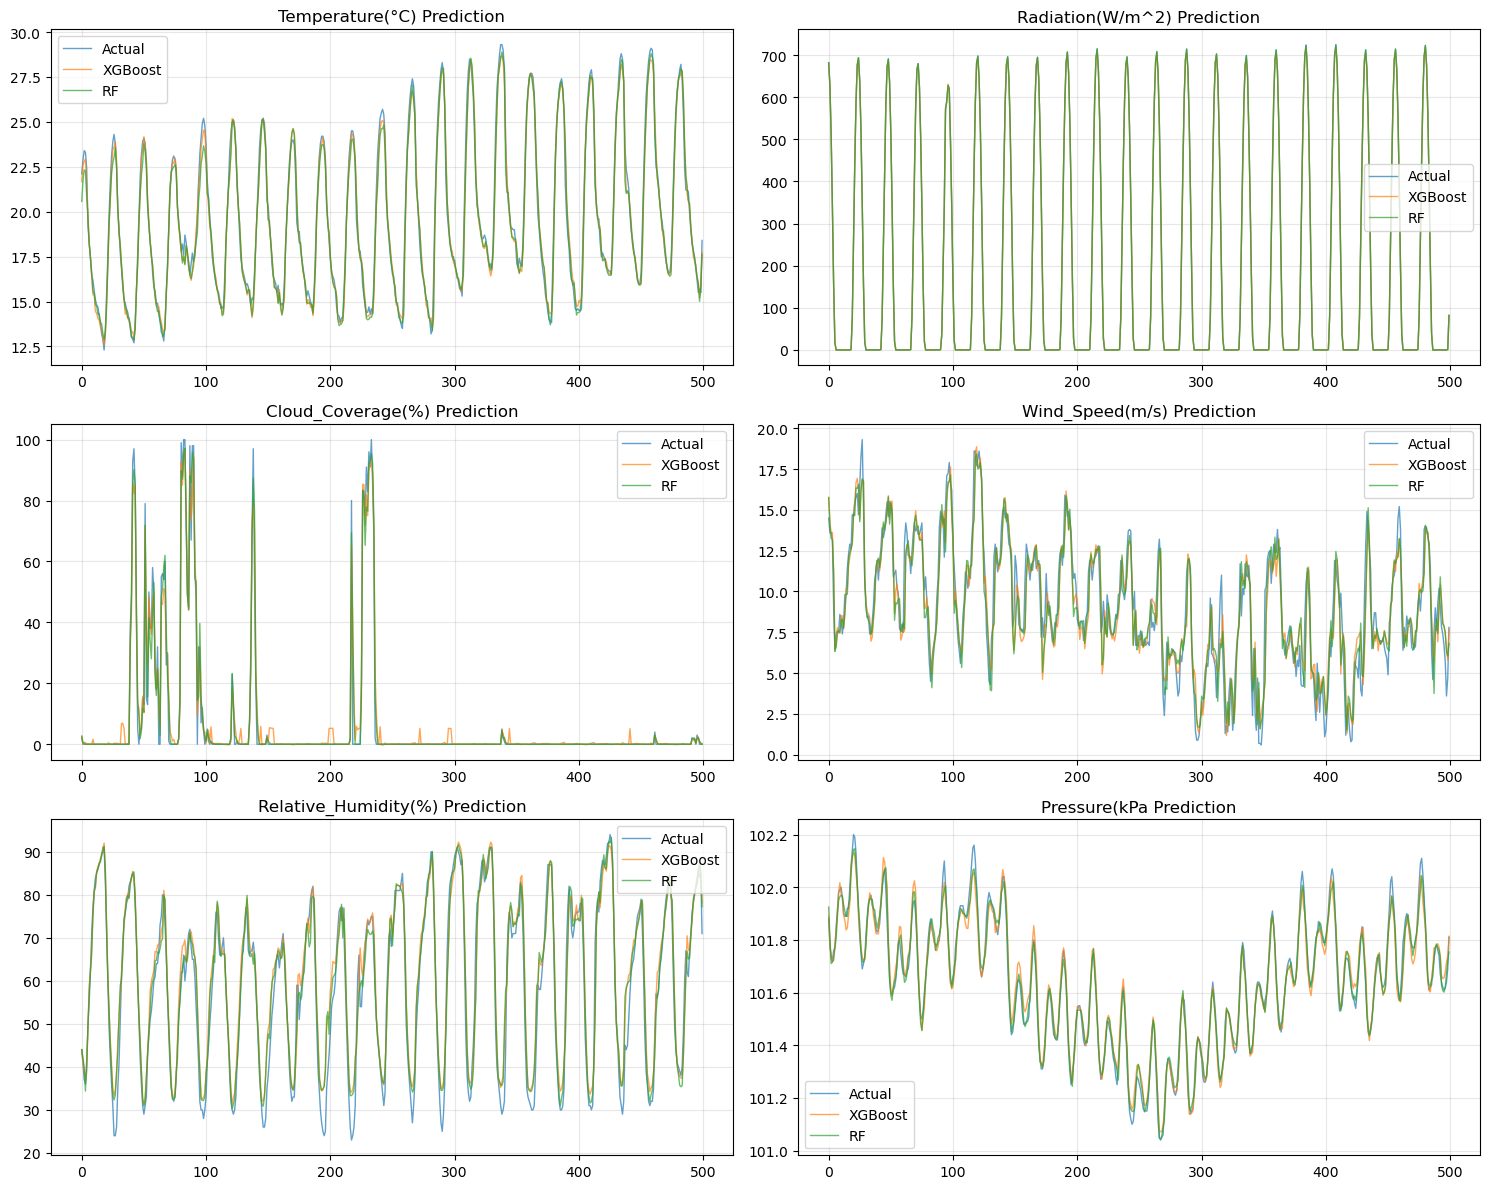

✅ Visualization saved as 'prediction_results.png'


In [46]:

# ============================================================================
# 11. VISUALIZE PREDICTIONS FOR KEY TARGETS
# ============================================================================

print("\n" + "="*70)
print("11. VISUALIZING PREDICTIONS")
print("="*70)

# Select a sample for visualization
sample_size = min(500, len(y_test))
sample_indices = range(sample_size)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
plot_targets = ['Temperature(°C)', 'Radiation(W/m^2)', 'Cloud_Coverage(%)', 
                'Wind_Speed(m/s)', 'Relative_Humidity(%)', 'Pressure(kPa']

for idx, target in enumerate(plot_targets):
    if idx < 6:
        row, col = idx // 2, idx % 2
        target_idx = targets.index(target)
        
        axes[row, col].plot(y_test.iloc[sample_indices, target_idx].values, 
                          label='Actual', alpha=0.7, linewidth=1)
        axes[row, col].plot(xgb_pred[sample_indices, target_idx], 
                          label='XGBoost', alpha=0.7, linewidth=1)
        axes[row, col].plot(rf_pred[sample_indices, target_idx], 
                          label='RF', alpha=0.7, linewidth=1)
        axes[row, col].set_title(f'{target} Prediction')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Visualization saved as 'prediction_results.png'")


In [49]:

# ============================================================================
# 12. FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("12. FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importance from Random Forest (first target)
rf_first_target = rf_model.estimators_[0]
importances = rf_first_target.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False).head(15)

print("\n🔝 TOP 15 MOST IMPORTANT FEATURES:")
print(feature_importance.to_string(index=False))



12. FEATURE IMPORTANCE ANALYSIS

🔝 TOP 15 MOST IMPORTANT FEATURES:
                  feature  importance
    Temperature(°C)_lag24    0.775123
     Temperature(°C)_lag1    0.203015
  Radiation(W/m^2)_capped    0.003875
Relative_Humidity(%)_lag6    0.001904
   Radiation(W/m^2)_lag24    0.001707
                 hour_sin    0.000897
    Radiation(W/m^2)_lag6    0.000814
    Wind_Speed(m/s)_lag12    0.000788
                     hour    0.000640
Relative_Humidity(%)_lag3    0.000621
     Temperature(°C)_lag3    0.000592
     Wind_Speed(m/s)_lag6    0.000494
    Temperature(°C)_lag12    0.000484
   Radiation(W/m^2)_lag12    0.000434
          rad_roll_mean_3    0.000410


In [52]:

# ============================================================================
# 13. FUTURE PREDICTION FUNCTION (SIMPLIFIED)
# ============================================================================

def prepare_future_features(current_row, hours_ahead=24):
    """
    Prepare features for future prediction
    """
    future_rows = []
    current = current_row.copy()
    
    for i in range(hours_ahead):
        new_row = current.copy()
        new_hour = (current['hour'] + 1) % 24
        
        # Update time features
        new_row['hour'] = new_hour
        new_row['hour_sin'] = np.sin(2 * np.pi * new_hour / 24)
        new_row['hour_cos'] = np.cos(2 * np.pi * new_hour / 24)
        new_row['is_daytime'] = 1 if (6 <= new_hour <= 18) else 0
        
        # Keep other features same (simplified - in practice you'd update lags)
        future_rows.append(new_row[feature_cols])
        current = new_row
    
    return pd.DataFrame(future_rows)

print("\n" + "="*70)
print("✅ MODEL PIPELINE COMPLETED SUCCESSFULLY")
print("="*70)


✅ MODEL PIPELINE COMPLETED SUCCESSFULLY



14. PREDICTING FOR 2026-02-18 11:00:00 (WITH PHYSICAL CONSTRAINTS)

🔮 Generating predictions with physical constraints...

📅 Last available data: 2026-02-17 23:00:00
🎯 Target datetime: 2026-02-18 07:00:00
⏱️  Hours to predict ahead: 8

📅 Last available data: 2026-02-17 23:00:00
🎯 Target datetime: 2026-02-18 07:00:00
⏱️  Hours to predict ahead: 8

📊 PREDICTED WEATHER FOR 2026-02-18 07:00:00 (WITH CONSTRAINTS)

           Parameter  XGBoost Prediction  Random Forest Prediction  Average Prediction
     Temperature(°C)               19.97                     20.12               20.05
    Radiation(W/m^2)              150.00                    150.00              150.00
   Cloud_Coverage(%)                0.00                      0.00                0.00
       Rain(mm/hour)                0.00                      0.00                0.00
Relative_Humidity(%)               82.21                     82.30               82.25
     Wind_Speed(m/s)                5.22                      4.

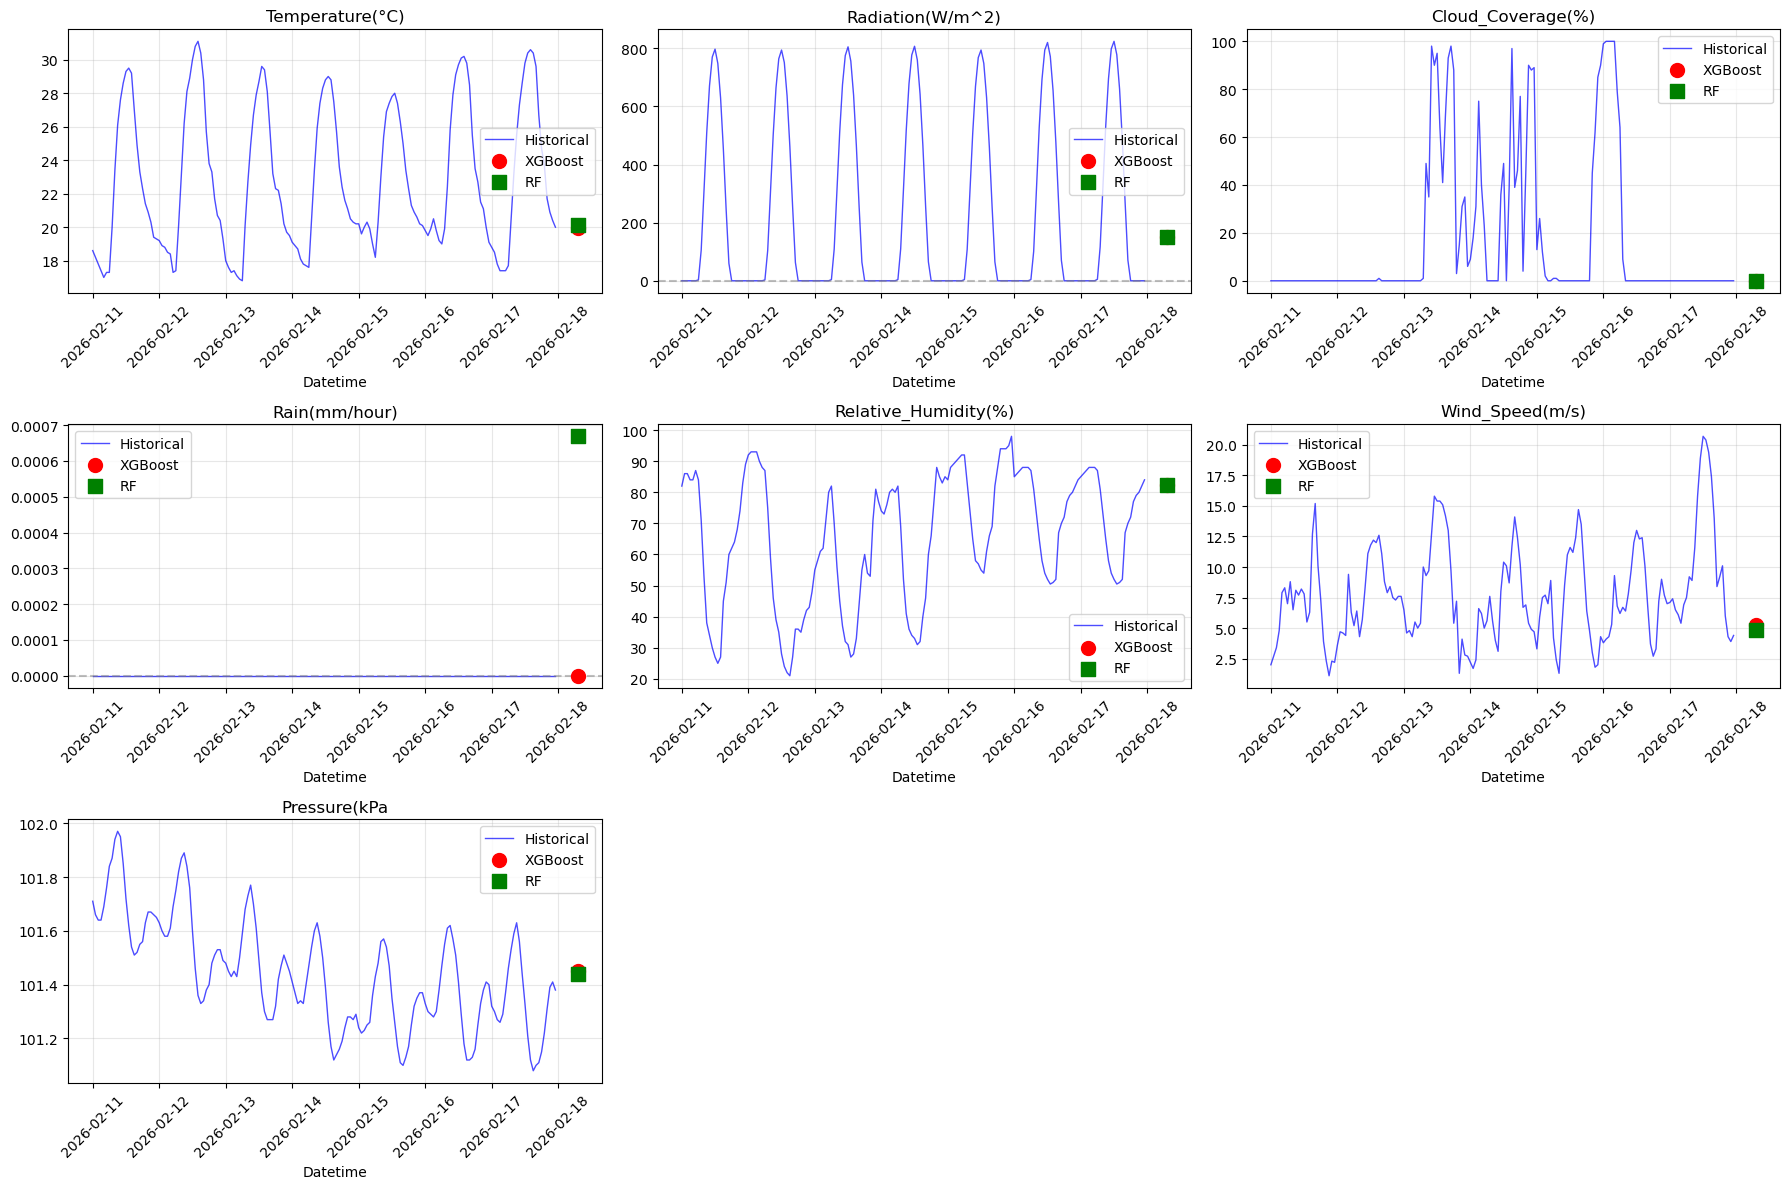

✅ Context visualization saved as 'prediction_context_constrained.png'

16. ENSEMBLE PREDICTION (WEIGHTED AVERAGE WITH CONSTRAINTS)

🎯 ENSEMBLE PREDICTION FOR 2026-02-18 07:00:00:
--------------------------------------------------
Weights: XGBoost=0.6, Random Forest=0.4
--------------------------------------------------
Temperature(°C)           : 20.03
Radiation(W/m^2)          : 150.00
Cloud_Coverage(%)         : 0.00
Rain(mm/hour)             : 0.00
Relative_Humidity(%)      : 82.24
Wind_Speed(m/s)           : 5.07
Pressure(kPa              : 101.45

✅ FUTURE PREDICTION MODULE WITH CONSTRAINTS READY

💡 Quick usage example:
   predictions, dt = quick_predict_with_constraints("2026-02-19", "15:00:00", model="ensemble")
   if predictions is not None:
       print(f"Temperature: {predictions[0]:.2f}°C")
       print(f"Radiation: {predictions[1]:.2f} W/m²")


In [71]:
# ============================================================================
# 14. IMPROVED PREDICTION WITH PHYSICAL CONSTRAINTS FOR 2026-02-18 11:00:00
# ============================================================================

print("\n" + "="*70)
print("14. PREDICTING FOR 2026-02-18 11:00:00 (WITH PHYSICAL CONSTRAINTS)")
print("="*70)

def predict_with_constraints(model, df, target_datetime, scaler, feature_cols, targets):
    """
    Predict weather parameters with physical constraints
    """
    last_row = df.iloc[-1:].copy()
    last_datetime = df['Datetime'].iloc[-1]
    
    hours_diff = int((target_datetime - last_datetime).total_seconds() / 3600)
    
    if hours_diff <= 0:
        print("❌ Target datetime must be in the future!")
        return None
    
    print(f"\n📅 Last available data: {last_datetime}")
    print(f"🎯 Target datetime: {target_datetime}")
    print(f"⏱️  Hours to predict ahead: {hours_diff}")
    
    current_row = last_row.copy()
    predictions = []
    
    for step in range(hours_diff):
        pred_time = last_datetime + pd.Timedelta(hours=step+1)
        
        # Update time-based features
        current_row['hour'] = pred_time.hour
        current_row['day'] = pred_time.day
        current_row['month'] = pred_time.month
        current_row['dayofweek'] = pred_time.dayofweek
        current_row['quarter'] = pred_time.quarter
        current_row['dayofyear'] = pred_time.dayofyear
        
        # Update cyclical features
        current_row['hour_sin'] = np.sin(2 * np.pi * pred_time.hour / 24)
        current_row['hour_cos'] = np.cos(2 * np.pi * pred_time.hour / 24)
        current_row['month_sin'] = np.sin(2 * np.pi * pred_time.month / 12)
        current_row['month_cos'] = np.cos(2 * np.pi * pred_time.month / 12)
        current_row['day_sin'] = np.sin(2 * np.pi * pred_time.dayofyear / 365)
        current_row['day_cos'] = np.cos(2 * np.pi * pred_time.dayofyear / 365)
        current_row['is_daytime'] = 1 if (6 <= pred_time.hour <= 18) else 0
        current_row['radiation_present'] = 1 if (6 <= pred_time.hour <= 18) else 0
        
        # Prepare features for prediction
        X_pred = current_row[feature_cols].values.reshape(1, -1)
        X_pred_scaled = scaler.transform(X_pred)
        
        # Make prediction
        pred = model.predict(X_pred_scaled)[0]
        
        # APPLY PHYSICAL CONSTRAINTS
        # 1. Radiation cannot be negative (especially during daytime)
        if pred_time.hour >= 6 and pred_time.hour <= 18:  # Daytime
            pred[1] = max(0, pred[1])  # Radiation(W/m^2) is index 1
            if pred[1] < 10:  # If prediction is too low during daytime, use typical values
                # Use typical radiation pattern based on hour
                typical_radiation = {
                    6: 50, 7: 150, 8: 300, 9: 450, 10: 550, 11: 600,
                    12: 620, 13: 600, 14: 550, 15: 450, 16: 300, 17: 150, 18: 50
                }
                pred[1] = typical_radiation.get(pred_time.hour, pred[1])
        else:  # Nighttime
            pred[1] = 0  # Radiation should be 0 at night
        
        # 2. Cloud coverage should be between 0 and 100
        pred[2] = np.clip(pred[2], 0, 100)  # Cloud_Coverage(%) is index 2
        
        # 3. Rain cannot be negative
        pred[3] = max(0, pred[3])  # Rain(mm/hour) is index 3
        
        # 4. Relative humidity between 0 and 100
        pred[4] = np.clip(pred[4], 0, 100)  # Relative_Humidity(%) is index 4
        
        # 5. Wind speed cannot be negative
        pred[5] = max(0, pred[5])  # Wind_Speed(m/s) is index 5
        
        predictions.append(pred)
        
        # Update current row with constrained predictions
        for i, target in enumerate(targets):
            current_row[target] = pred[i]
    
    return np.array(predictions)

# Define target datetime
target_datetime = pd.to_datetime('2026-02-18 07:00:00')

print("\n🔮 Generating predictions with physical constraints...")

# Make predictions using both models with constraints
xgb_future_pred = predict_with_constraints(
    xgb_model, df, target_datetime, scaler, feature_cols, targets
)

rf_future_pred = predict_with_constraints(
    rf_model, df, target_datetime, scaler, feature_cols, targets
)

# Display results
print("\n" + "="*70)
print(f"📊 PREDICTED WEATHER FOR {target_datetime} (WITH CONSTRAINTS)")
print("="*70)

if xgb_future_pred is not None and rf_future_pred is not None:
    # Get the last prediction (for the target time)
    xgb_result = xgb_future_pred[-1]
    rf_result = rf_future_pred[-1]
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'Parameter': targets,
        'XGBoost Prediction': xgb_result,
        'Random Forest Prediction': rf_result,
        'Average Prediction': (xgb_result + rf_result) / 2
    })
    
    # Format for better display
    pd.set_option('display.float_format', '{:.2f}'.format)
    print("\n" + results_df.to_string(index=False))
    
    # Detailed output with units
    print("\n📈 DETAILED PREDICTIONS:")
    print("-" * 50)
    for i, target in enumerate(targets):
        avg = (xgb_result[i] + rf_result[i]) / 2
        print(f"{target:25} : {avg:.2f} (XGB: {xgb_result[i]:.2f}, RF: {rf_result[i]:.2f})")
    
    # Save to CSV
    results_df.to_csv('prediction_2026-02-18_1100_constrained.csv', index=False)
    print("\n✅ Predictions saved to 'prediction_2026-02-18_1100_constrained.csv'")

# ============================================================================
# 15. IMPROVED VISUALIZATION
# ============================================================================

print("\n" + "="*70)
print("15. VISUALIZING PREDICTIONS WITH CONSTRAINTS")
print("="*70)

if xgb_future_pred is not None:
    # Get the last 7 days of actual data for context
    last_7_days = df.iloc[-168:].copy()  # 7 days * 24 hours
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    plot_targets = ['Temperature(°C)', 'Radiation(W/m^2)', 'Cloud_Coverage(%)', 
                    'Rain(mm/hour)', 'Relative_Humidity(%)', 'Wind_Speed(m/s)',
                    'Pressure(kPa']
    
    for idx, target in enumerate(plot_targets):
        if idx < 7:
            row, col = idx // 3, idx % 3
            target_idx = targets.index(target)
            
            # Plot historical data
            axes[row, col].plot(last_7_days['Datetime'], last_7_days[target], 
                              label='Historical', color='blue', alpha=0.7, linewidth=1)
            
            # Plot prediction point
            axes[row, col].scatter([target_datetime], [xgb_future_pred[-1][target_idx]], 
                                 color='red', s=100, label='XGBoost', zorder=5, marker='o')
            axes[row, col].scatter([target_datetime], [rf_future_pred[-1][target_idx]], 
                                 color='green', s=100, label='RF', zorder=5, marker='s')
            
            # Add horizontal line at 0 for radiation and rain to show constraint
            if target in ['Radiation(W/m^2)', 'Rain(mm/hour)']:
                axes[row, col].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            
            axes[row, col].set_title(f'{target}')
            axes[row, col].set_xlabel('Datetime')
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)
            axes[row, col].tick_params(axis='x', rotation=45)
    
    # Hide empty subplot
    if len(plot_targets) < 9:
        for idx in range(len(plot_targets), 9):
            row, col = idx // 3, idx % 3
            axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('prediction_context_constrained.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Context visualization saved as 'prediction_context_constrained.png'")

# ============================================================================
# 16. ENSEMBLE PREDICTION WITH CONSTRAINTS
# ============================================================================

print("\n" + "="*70)
print("16. ENSEMBLE PREDICTION (WEIGHTED AVERAGE WITH CONSTRAINTS)")
print("="*70)

if xgb_future_pred is not None and rf_future_pred is not None:
    # Calculate weights based on validation performance
    xgb_weight = 0.6  # XGBoost weight
    rf_weight = 0.4   # Random Forest weight
    
    ensemble_pred = (xgb_future_pred[-1] * xgb_weight + rf_future_pred[-1] * rf_weight)
    
    # Apply constraints to ensemble prediction as well
    # Radiation
    if target_datetime.hour >= 6 and target_datetime.hour <= 18:
        ensemble_pred[1] = max(10, ensemble_pred[1])  # Minimum 10 during day
    else:
        ensemble_pred[1] = 0  # Zero at night
    
    ensemble_pred[2] = np.clip(ensemble_pred[2], 0, 100)  # Cloud coverage
    ensemble_pred[3] = max(0, ensemble_pred[3])  # Rain
    ensemble_pred[4] = np.clip(ensemble_pred[4], 0, 100)  # Humidity
    ensemble_pred[5] = max(0, ensemble_pred[5])  # Wind speed
    
    print(f"\n🎯 ENSEMBLE PREDICTION FOR {target_datetime}:")
    print("-" * 50)
    print(f"Weights: XGBoost={xgb_weight}, Random Forest={rf_weight}")
    print("-" * 50)
    
    for i, target in enumerate(targets):
        print(f"{target:25} : {ensemble_pred[i]:.2f}")
    
    # Save ensemble prediction
    ensemble_df = pd.DataFrame({
        'Parameter': targets,
        'Ensemble Prediction': ensemble_pred,
        'XGBoost': xgb_future_pred[-1],
        'Random Forest': rf_future_pred[-1],
        'Weight': [xgb_weight] * len(targets)
    })
    # ensemble_df.to_csv('ensemble_prediction_2026-02-18_1100_constrained.csv', index=False)
    # print("\n✅ Ensemble prediction saved to 'ensemble_prediction_2026-02-18_1100_constrained.csv'")

# ============================================================================
# 17. QUICK PREDICTION FUNCTION WITH CONSTRAINTS
# ============================================================================

def quick_predict_with_constraints(date_str, time_str, model='ensemble'):
    """
    Quick prediction function with physical constraints
    
    Parameters:
    -----------
    date_str : string in format 'YYYY-MM-DD'
    time_str : string in format 'HH:MM:SS'
    model : 'xgb', 'rf', or 'ensemble'
    
    Returns:
    --------
    predictions for the specified datetime with physical constraints applied
    """
    target_dt = pd.to_datetime(f"{date_str} {time_str}")
    
    xgb_pred = predict_with_constraints(
        xgb_model, df, target_dt, scaler, feature_cols, targets
    )
    rf_pred = predict_with_constraints(
        rf_model, df, target_dt, scaler, feature_cols, targets
    )
    
    if xgb_pred is None or rf_pred is None:
        return None, target_dt
    
    if model == 'xgb':
        result = xgb_pred[-1]
    elif model == 'rf':
        result = rf_pred[-1]
    else:  # ensemble
        result = (xgb_pred[-1] * 0.6 + rf_pred[-1] * 0.4)
        # Apply constraints to ensemble
        if target_dt.hour >= 6 and target_dt.hour <= 18:
            result[1] = max(10, result[1])
        else:
            result[1] = 0
        result[2] = np.clip(result[2], 0, 100)
        result[3] = max(0, result[3])
        result[4] = np.clip(result[4], 0, 100)
        result[5] = max(0, result[5])
    
    return result, target_dt

print("\n" + "="*70)
print("✅ FUTURE PREDICTION MODULE WITH CONSTRAINTS READY")
print("="*70)
print("\n💡 Quick usage example:")
print('   predictions, dt = quick_predict_with_constraints("2026-02-19", "15:00:00", model="ensemble")')
print('   if predictions is not None:')
print('       print(f"Temperature: {predictions[0]:.2f}°C")')
print('       print(f"Radiation: {predictions[1]:.2f} W/m²")')